# Comparación de Modelos.

El teorema de Bayes también se puede utilizar para comparar dos modelos distintos y decidir cuál es más apropiado para los datos.

En este notebook utilizaremos los mismos datos que en el notebook `Bayes-intro.ipynb`. Modelaremos los datos con una línea recta y con una parábola.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal

In [2]:
plt.style.use(['ggplot', 'demo.mplstyle'])

In [3]:
datos = np.loadtxt('experimento.dat')
x = datos[:, 0]
y = datos[:, 1]
e_y = datos[:, 2]

Ajustemos primero una línea recta y una parábola utilizando un método de máxima verosimilitud.

In [4]:
def recta(x, *pars):
    m, n = pars
    output = m * x + n
    return output

def parabola(x, *pars):
    a, b, c = pars
    output = a * x**2 + b * x + c
    return output

In [5]:
mle_recta, _ = curve_fit(recta, x, y, p0=[2., -1.], sigma=e_y)
mle_parabola, _ = curve_fit(parabola, x, y, p0=[0, 2., -1], sigma=e_y)

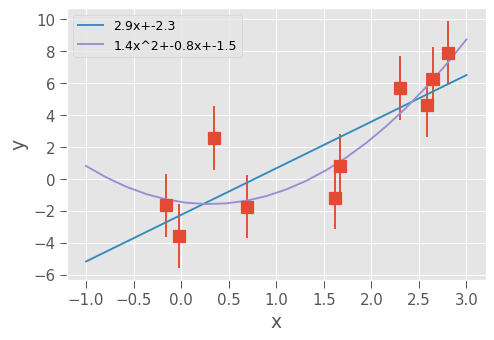

In [6]:
x_to_plot = np.linspace(-1, 3, 20)

plt.errorbar(x, y, yerr=e_y, ls='None', marker='s')
plt.plot(x_to_plot, recta(x_to_plot, *mle_recta), 
         label='{:.1f}x+{:.1f}'.format(*mle_recta))
plt.plot(x_to_plot, parabola(x_to_plot, *mle_parabola), 
         label='{:.1f}x^2+{:.1f}x+{:.1f}'.format(*mle_parabola))


plt.legend()
plt.xlabel('x')
plt.ylabel('y');

Podemos ver a simple vista que la parábola se ajusta mejor a los datos. Pero hasta cuando se justifica aumentar el grado del polinomio?

Veamos por ejemplo un ajuste con un polinomio de alto grado:

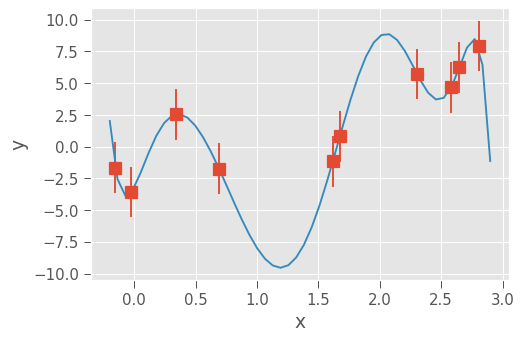

In [7]:
x_to_plot = np.linspace(-0.2, 2.9, 50)

p = np.polyfit(x, y, 9)  # un ajuste simple de polinomio

plt.errorbar(x, y, yerr=e_y, ls='None', marker='s')
plt.plot(x_to_plot, np.polyval(p, x_to_plot)) 

plt.xlabel('x')
plt.ylabel('y');

**Lo que buscamos es un balance entre el mejor ajuste y la simplicidad del modelo.**

## El Factor de Bayes

Necesitamos calcular las evidencias asociadas a la recta y a la parábola. Para eso, necesitamos calcular la integral sobre todo el dominio de los parámetros de la verosimilitud por el prior.

Definiremos priors gausianos en 2D y 3D y calcularemos las verosimilitudes asumiendo modelos con ruido gausiano.

In [8]:
# Los priors

mu_recta = [3, -2]  # Arbitrario
sigma_recta = [[100**2,      0],
               [     0, 100**2]]  # Arbitrario, poco informativo, 2D
prior_recta_rv = multivariate_normal(mu_recta, sigma_recta)

mu_parabola = [1, -2, -2]
sigma_parabola = [[100**2,      0,      0],
                  [     0, 100**2,      0],
                  [     0,      0, 100**2]]  # Arbitrario, poco informativo, 3D
prior_parabola_rv = multivariate_normal(mu_parabola, sigma_parabola)

In [9]:
# Prior para la recta

dm = dn = 0.1
m, n = np.mgrid[-1:7:dm, -6:2:dn]
posiciones_recta = np.empty(m.shape + (2,))
posiciones_recta[:,:,0] = m
posiciones_recta[:,:,1] = n

prior_recta = prior_recta_rv.pdf(posiciones_recta)

In [10]:
# Prior para la parabola

da = db = dc = 0.1
a, b, c = np.mgrid[-2:5:da, -9:9:db, -6:3:dc]
posiciones_parabola = np.empty(a.shape + (3,))
posiciones_parabola[:,:,:,0] = a
posiciones_parabola[:,:,:,1] = b
posiciones_parabola[:,:,:,2] = c

prior_parabola = prior_parabola_rv.pdf(posiciones_parabola)

Ahora debemos calcular la verosimilitud

In [11]:
# Esta función general nos permitirá calcular para los dos modelos

def verosimilitud(modelo, parametros, x, y, e_y):
    exp = np.exp(-(y - modelo(x, *parametros))**2 / (2 * e_y**2))
    verosimilitudes = exp / np.sqrt(2 * np.pi * e_y**2)
    output = np.prod(verosimilitudes)
    return output

In [12]:
likelihood_recta = np.zeros(m.shape)

ni, nj = m.shape
for i in range(ni):
    for j in range(nj):
        pars = m[i,0], n[0, j]
        likelihood_recta[i, j] = verosimilitud(recta, pars, x, y, e_y)

In [13]:
likelihood_parabola = np.zeros(a.shape)

ni, nj, nk = a.shape
for i in range(ni):
    for j in range(nj):
        for k in range(nk):
            pars = a[i, 0, 0], b[0, j, 0], c[0, 0, k]
            likelihood_parabola[i, j, k] = verosimilitud(parabola, pars, x, y, e_y)

Con esto podemos calcular las posteriores y visualizarlas.

In [14]:
posterior_recta = likelihood_recta * prior_recta
posterior_parabola = likelihood_parabola * prior_parabola

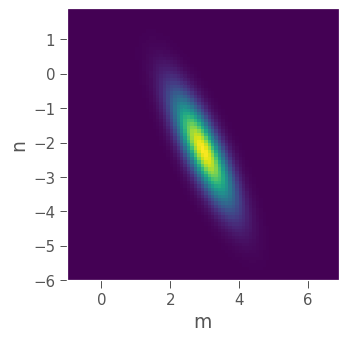

In [15]:
# Visualización de la posterior en 2D

fig = plt.figure(1)

ax1 = fig.add_subplot(111)
ax1.set_aspect('equal')
ax1.pcolormesh(m, n, posterior_recta)

plt.xlabel('m')
plt.ylabel('n');

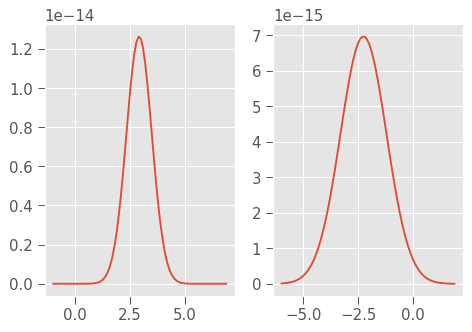

In [16]:
# También es útil explorar las probabilidades marginales.
# Para la posterior marginal P(m), hay que integrar las probabilidades 2D en n.
# y para P(n), hay que integrar en m. Esto lo hacemos de manera muy simple.

fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax1.plot(m[:,0], np.sum(posterior_recta, axis=1) * dn)

ax2 = fig.add_subplot(122)
ax2.plot(n[0,:], np.sum(posterior_recta, axis=0) * dm);

Visualizar la posterior para la parábola es más difícil, porque está definida en 3D. En este caso, una estrategia común es visualizar las probabilidades marginales 2D. Para eso, hay que integrar en una de las dimensiones cada vez. Esto lo hacemos de la misma manera simple que en el caso 2D.

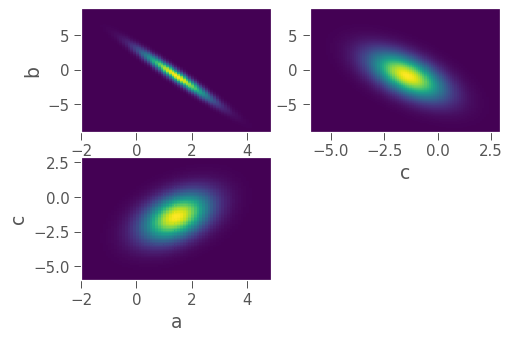

In [17]:
fig = plt.figure(1)
ax1 = fig.add_subplot(221)
ax1.pcolormesh(a[:,:,0], b[:,:,0], np.sum(posterior_parabola, axis=2)*dc) #  np.sum() * dc para la marginal (a,b)
plt.ylabel('b')

ax2 =fig.add_subplot(223)
ax2.pcolormesh(a[:,0,:], c[:,0,:], np.sum(posterior_parabola, axis=1)*db) #  np.sum() * db para la marginal (a,c)
plt.ylabel('c')
plt.xlabel('a')

ax3 =fig.add_subplot(222)
ax3.pcolormesh(c[0,:,:], b[0,:,:], np.sum(posterior_parabola, axis=0)*da) #  np.sum() * da para la marginal (b,c)
plt.xlabel('c');

El gráfico anterior es bastante común. Se ordenan las combinaciones entre todos los pares de parámetros de modo que se forme un triángulo superior o inferior.

Estas probabilidades marginales 2D a veces van acompañadas de las probabilidades marginales 1D, que nosotros graficamos por separado a continuación.

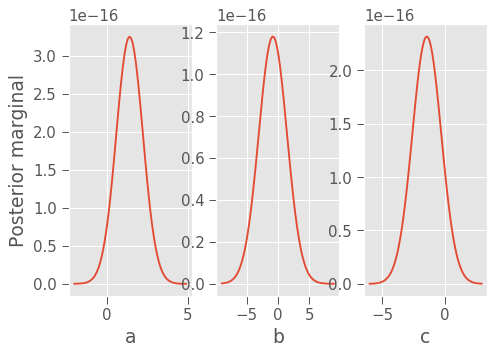

In [18]:
fig = plt.figure(1)

ax1 = fig.add_subplot(131)
ax1.plot(a[:,0,0], np.sum(posterior_parabola, axis=(1,2))*db*dc)  # axis=(1,2) suma sobre el eje 1, y sobre el 2
ax1.set_xlabel('a')
ax1.set_ylabel('Posterior marginal')

ax2 = fig.add_subplot(132)
ax2.plot(b[0,:,0], np.sum(posterior_parabola, axis=(0,2))*da*dc)
ax2.set_xlabel('b')

ax3 = fig.add_subplot(133)
ax3.plot(c[0,0,:], np.sum(posterior_parabola, axis=(0,1))*da*db)
ax3.set_xlabel('c');

Ahora podemos estimar las evidencias haciendo una integral simple de la posterior

In [19]:
E_recta = np.sum(posterior_recta) * dm * dn
E_parabola = np.sum(posterior_parabola) * da * db * dc

Las evidencias que estimamos en la celda anterior, las hicimos haciendo sumas de rectangulos 3D. La evidencia debe ser la suma sobre TODO EL DOMINIO. Claramente no sumamos sobre todo el dominio, pero de acuerdo a los gráficos de las marginales, sumamos sobre casi todo el dominio en el cual la posterior no es insignificante.

Pero como saber cual es esa región donde la posterior no es insignificante?
Por ahora, solo prueba y error. Los estimadores de maxima verosimilitud que hice al principio me ayudaron a encontrar, más o menos esta región. Luego fui iterando hasta cubrir toda la región importante (extendiendo los rangos de a, b y c).

Claramente esto no es lo más eficiente. Hay formas mejores pero esas requieren otros métodos que no hemos visto aún. En particular, los métodos de Monte Carlo (MCMC, Markov Chain Monte Carlo), pueden ubicar automáticamente esta región de alta probabilidad posterior.

Finalmente podemos calcular la razón entre las evidencias.

Asumiremos que la razón entre las probabilidades a priori asociadas a cada modelo es 1 (es decir, no le daremos preferencia a ninguno).

In [20]:
prior_modelo_recta = 1.
prior_modelo_parabola = 1.

In [21]:
O12 = (E_recta / E_parabola) * (prior_modelo_recta / prior_modelo_parabola)

In [22]:
print("P(Recta|D) / P(Parabola|D) = {:.1f}".format(O12))

P(Recta|D) / P(Parabola|D) = 27.5


Como podemos ver, a pesar de que la parábola parece pasar más cerca de los puntos, O12 es >1, esto quiere decir que el modelo "línea recta" tiene mayor probabilidad que la parábola. Lo que está pasando es que la penalidad que tiene la parábola al explorar un dominio mucho más grande, no se contrarresta lo suficiente por la mejora en la verosimilitud.

Una guía referncial para decidir cuándo elegir un modelo sobre el otro basado en este cuociente de probabilidades, la provee Jeffreys (1961) en un apéndice comúnmente utilizado.

## Apendice de Jeffreys (1961)

("null hypothesis, H0": se prefiere M1 sobre M2)

O12 > 1 ⇒ “Null hypothesis supported.”

O12 < 1 ⇒ “Not worth more than bare mention.”

O12 < 1/$\sqrt{10}$ ⇒ “Evidence against H0 substantial.”

O12 < 1/10 ⇒ “strong”

O12 < 1/10$^{3/2}$ ⇒ “very strong”

O12 < 1/100 ⇒ “Evidence against H0 decisive.”